## Finetune Llama-2-7b using QLora on a Google colab

Running large language models (LLMs) requires a lot of GPU power and memory, which can be costly. To improve performance and reduce costs, lightweight LLM models are being explored. This blog will cover key techniques for deploying LLMs more efficiently and affordably.

This example shows **How to fine-tine Llama-2-7B model using Instruction tuning with PEFT and QLoRA**.


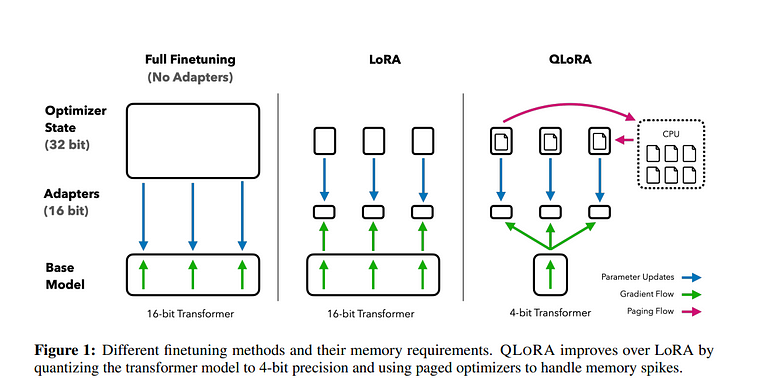

## Setup

Run the cells below to setup and install the required libraries. For our experiment we will need `accelerate`, `peft`, `transformers`, `datasets` and TRL to leverage the recent [`SFTTrainer`](https://huggingface.co/docs/trl/main/en/sft_trainer). We will use `bitsandbytes` to [quantize the base model into 4bit](https://huggingface.co/blog/4bit-transformers-bitsandbytes). We will also install `einops` as it is a requirement to load Falcon models.

In [ ]:
# install required libraries

!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4

In [ ]:
# import libraries and modules

import json
import os
from pprint import pprint

import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from huggingface_hub import notebook_login

from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

### Connect with HF account

Follow the Instructions to generate huggingfaces token with write access

Create an account, if you don't have account in Hugging Face. If it is already present then

***Go to Profile -> Access Tokens -> Create a token with write access -> Copy it and use it for login***

In [ ]:
# login with hugging face token
notebook_login()

In [ ]:
# check for VRAM of GPU
!nvidia-smi

Wed Jan 24 11:09:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Download data for tuning

In [ ]:
# download ecommerce-faq.json

!gdown 1tiAscG941evQS8RzjznoPu8meu4unw5A

Downloading...
From: https://drive.google.com/uc?id=1tiAscG941evQS8RzjznoPu8meu4unw5A
To: /content/ecommerce-faq.json
100% 21.0k/21.0k [00:00<00:00, 45.3MB/s]


### Data loading and understanding

In [ ]:
# loading and reading values in ecommerce-faq.json

with open("ecommerce-faq.json") as json_file:
    data = json.load(json_file)

In [ ]:
pprint(data["questions"][0], sort_dicts=False)

{'question': 'How can I create an account?',
 'answer': "To create an account, click on the 'Sign Up' button on the top "
           'right corner of our website and follow the instructions to '
           'complete the registration process.'}


In [ ]:
pprint(data["questions"][1], sort_dicts=False)

{'question': 'What payment methods do you accept?',
 'answer': 'We accept major credit cards, debit cards, and PayPal as payment '
           'methods for online orders.'}


In [ ]:
pprint(data["questions"][3], sort_dicts=False)

{'question': 'What is your return policy?',
 'answer': 'Our return policy allows you to return products within 30 days of '
           'purchase for a full refund, provided they are in their original '
           'condition and packaging. Please refer to our Returns page for '
           'detailed instructions.'}


In [ ]:
# reading dataset.json for Q&A
with open("dataset.json", "w") as f:
    json.dump(data["questions"], f)

In [ ]:
pd.DataFrame(data["questions"]).head()

,question,answer
0,How can I create an account?,"To create an account, click on the 'Sign Up' b..."
1,What payment methods do you accept?,"We accept major credit cards, debit cards, and..."
2,How can I track my order?,You can track your order by logging into your ...
3,What is your return policy?,Our return policy allows you to return product...
4,Can I cancel my order?,You can cancel your order if it has not been s...


We’re using a sharded model, which means the model is split into multiple parts—around 14 pieces in this case. This helps accelerate the process by allowing different pieces to be loaded into various memory types, like GPU or CPU memory. This way, you can work with and fine-tune a large model even with limited memory, which is why we use the sharded approach.

### Changing the quantization type

The 4bit integration comes with 2 different quantization types: FP4 and NF4. The NF4 dtype stands for Normal Float 4 and is introduced in the [QLoRA paper](https://arxiv.org/abs/2305.14314)

YOu can switch between these two dtype using `bnb_4bit_quant_type` from `BitsAndBytesConfig`. By default, the FP4 quantization is used.

In [ ]:
# Load Llama-7b bf16 sharded Model & tokenizer

MODEL_NAME = "TinyPixel/Llama-2-7B-bf16-sharded"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

# model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    quantization_config=bnb_config,
)

# tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/626 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/28.1k [00:00<?, ?B/s]

model-00001-of-00014.safetensors:   0%|          | 0.00/981M [00:00<?, ?B/s]

model-00002-of-00014.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

model-00003-of-00014.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

model-00004-of-00014.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00005-of-00014.safetensors:   0%|          | 0.00/944M [00:00<?, ?B/s]

model-00006-of-00014.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00007-of-00014.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

model-00008-of-00014.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

model-00009-of-00014.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00010-of-00014.safetensors:   0%|          | 0.00/944M [00:00<?, ?B/s]

model-00011-of-00014.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

model-00012-of-00014.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

model-00013-of-00014.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

model-00014-of-00014.safetensors:   0%|          | 0.00/847M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/676 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [ ]:
# helper function to print number of trainable parameters

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable params: {trainable_params} || All params: {all_param} || Trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

### Lora Config

LoraConfig allows you to control how LoRA is applied to the base model through the following parameters - \

***r*** - the rank of the update matrices, expressed in int. Lower rank results in smaller update matrices with fewer trainable parameters. \

***target_modules*** - The modules (for example, attention blocks) to apply the LoRA update matrices. \

***alpha***  - LoRA scaling factor. \

***bias*** - Specifies if the bias parameters should be trained. Can be 'none', 'all' or 'lora_only'. \

***modules_to_save*** - List of modules apart from LoRA layers to be set as trainable and saved in the final checkpoint. These typically include model’s custom head that is randomly initialized for the fine-tuning task.
***layers_to_transform*** - List of layers to be transformed by LoRA. If not specified, all layers in target_modules are transformed. \

***layers_pattern*** - Pattern to match layer names in target_modules, if layers_to_transform is specified. By default PeftModel will look at common layer pattern (layers, h, blocks, etc.), use it for exotic and custom models. \

***rank_pattern*** - The mapping from layer names or regexp expression to ranks which are different from the default rank specified by r. \

***alpha_pattern*** - The mapping from layer names or regexp expression to alphas which are different from the default alpha specified by lora_alpha.

In [ ]:
from peft import LoraConfig, get_peft_model

# set Loraconfig parameter values

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

Trainable params: 33554432 || All params: 3533967360 || Trainable%: 0.9494833591219133


### Inference Before Training

In [ ]:
prompt = f"""
: How can I create an account?
:
""".strip()
print(prompt)

: How can I create an account?
:


In [ ]:
# change configuration for generation

generation_config = model.generation_config
generation_config.max_new_tokens = 80
generation_config.temperature = 0.7
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [ ]:
# generation configurations
generation_config

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 2,
  "max_new_tokens": 80,
  "pad_token_id": 2,
  "temperature": 0.7,
  "top_p": 0.7
}

In [ ]:
%%time
# Specify the target device for model execution, typically a GPU.
device = "cuda:0"

# Tokenize the input prompt and move it to the specified device.
encoding = tokenizer(prompt, return_tensors="pt").to(device)

# Run model inference in evaluation mode (inference_mode) for efficiency.
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,
    )


# Decode the generated output and print it, excluding special tokens.
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


: How can I create an account?
: How can I create an account?
: How can I create an account? : How can I create an account?
CPU times: user 6.25 s, sys: 826 ms, total: 7.08 s
Wall time: 11.4 s


### Build HuggingFace Dataset format

In [ ]:
data = load_dataset("json", data_files="dataset.json")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['answer', 'question'],
        num_rows: 79
    })
})

In [ ]:
data["train"][0]

{'answer': "To create an account, click on the 'Sign Up' button on the top right corner of our website and follow the instructions to complete the registration process.",
 'question': 'How can I create an account?'}

In [ ]:
def generate_prompt(data_point):
    return f"""
: {data_point["question"]}
: {data_point["answer"]}
""".strip()


def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(data_point)
    tokenized_full_prompt = tokenizer(full_prompt, padding=True, truncation=True)
    return tokenized_full_prompt

In [ ]:
data = data["train"].shuffle().map(generate_and_tokenize_prompt)

Map:   0%|          | 0/79 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
data

Dataset({
    features: ['answer', 'question', 'input_ids', 'attention_mask'],
    num_rows: 79
})

In [ ]:
OUTPUT_DIR = "experiments"

In [ ]:
# training
training_args = transformers.TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    num_train_epochs=1,
    learning_rate=2e-4,
    fp16=True,
    save_total_limit=3,
    logging_steps=1,
    output_dir=OUTPUT_DIR,
    max_steps=80,
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.05,
    report_to="tensorboard",
)

trainer = transformers.Trainer(
    model=model,
    train_dataset=data,
    args=training_args,
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,2.275600
2,2.245900
3,1.933500
4,1.858800
5,2.012600
6,1.801800
7,1.794000
8,1.489300
9,1.587700
10,1.560400


TrainOutput(global_step=80, training_loss=0.8391439635306597, metrics={'train_runtime': 447.6633, 'train_samples_per_second': 0.715, 'train_steps_per_second': 0.179, 'total_flos': 649997819142144.0, 'train_loss': 0.8391439635306597, 'epoch': 4.05})

I trained it for 100 epochs, and as you can observe, the loss consistently decreases, indicating room for further improvement.

NOTE: ***Consider extending the training to a higher number of epochs for potential enhancements***

### Save model in local system

In [ ]:
model.save_pretrained("trained-model")

### Push trained model in Hugging face

NOTE: ***Here you have to change directory where you want to push your model***.

For me it is "Prasant/Llama2-7b-qlora-chat-support-bot-faq"

In [ ]:
model.push_to_hub("Prasant/Llama2-7b-qlora-chat-support-bot-faq")

adapter_model.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Prasant/Llama2-7b-qlora-chat-support-bot-faq/commit/afdc083726f49ccf925eda01e564e2a9520d92f3', commit_message='Upload model', commit_description='', oid='afdc083726f49ccf925eda01e564e2a9520d92f3', pr_url=None, pr_revision=None, pr_num=None)

In our approach, we've split the large model TinyPixel/Llama-2-7B-bf16 into more than 14 smaller parts, a method known as sharding. This strategy works well with the `accelerate` framework by huggingface.

Each shard holds part of the model's data, and Accelerate helps distribute these parts across different memory types, like GPU and CPU. This way, we can handle large models without needing too much memory.

### Load pushed model

Load model from the directory you pushed, for me it is "Prasant/Llama2-7b-qlora-chat-support-bot-faq"

In [ ]:
PEFT_MODEL = "Prasant/Llama2-7b-qlora-chat-support-bot-faq"

# loading trained model from hugging face
config = PeftConfig.from_pretrained(PEFT_MODEL)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token

model = PeftModel.from_pretrained(model, PEFT_MODEL)

adapter_config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/14 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

### Do experiments with parameters and see what works for you and your data best

In [ ]:
# model configuration, you can try changing these parameters
generation_config = model.generation_config
generation_config.max_new_tokens = 50

# try using temperature parameter by uncommenting following
# generation_config.temperature = 0.3
generation_config.top_p = 0.7
generation_config.num_return_sequences = 1
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.eos_token_id = tokenizer.eos_token_id

In [ ]:
# device configuration
DEVICE = "cuda:0"

In [ ]:
%%time
prompt = f"""
: How can I create an account?
:
""".strip()

encoding = tokenizer(prompt, return_tensors="pt").to(DEVICE)
with torch.inference_mode():
    outputs = model.generate(
        input_ids=encoding.input_ids,
        attention_mask=encoding.attention_mask,
        generation_config=generation_config,

    )
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

: How can I create an account?
: To create an account, click on the 'Sign Up' button on the top right corner of the website. Follow the instructions to complete the registration process.
: You can place an order by adding items to your shopping cart and proceeding to
CPU times: user 4.37 s, sys: 252 ms, total: 4.62 s
Wall time: 4.68 s


In [ ]:
# helper function to generate responses
def generate_response(question: str) -> str:
    prompt = f"""
: {question}
:
""".strip()
    encoding = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    with torch.inference_mode():
        outputs = model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config,
        )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    assistant_start = ":"
    response_start = response.find(assistant_start)
    return response[response_start + len(assistant_start) :].strip()

In [ ]:
# prompt
prompt = "Question: Can I return a product if it was a clearance or final sale item?"
print(generate_response(prompt))

Question: Can I return a product if it was a clearance or final sale item?
: Clearance or final sale items are typically non-returnable. Please refer to the product description or contact our customer support team for specific return instructions.
: You can request a return by contacting our customer support team. We will provide you with


In [ ]:
# prompt
prompt = "Question: What happens when I return a clearance item?"
print(generate_response(prompt))

Question: What happens when I return a clearance item?
: Clearance items are non-refundable and non-exchangeable. However, you can request a store credit for the full value of the item. Please contact our customer support team for assistance.
: We accept returns within 30 days


In [ ]:
# prompt
prompt = "Question: How do I know when I'll receive my order?"
print(generate_response(prompt))

Question: How do I know when I'll receive my order?
: Once you place an order, we will send you a confirmation email with your order details and estimated delivery time. You can track your order's progress by logging into your account or checking your order confirmation email.
: If you need to


In [ ]:
################ falcon with lama2
# https://github.com/curiousily/Get-Things-Done-with-Prompt-Engineering-and-LangChain/blob/master/07.falcon-qlora-fine-tuning.ipynb

## That's it; you can try to play with these hyperparameters to achieve better results 🎉

If you liked this guide, do consider giving a 🌟 to LanceDB's [vector-recipes](https://github.com/lancedb/vectordb-recipes)